In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

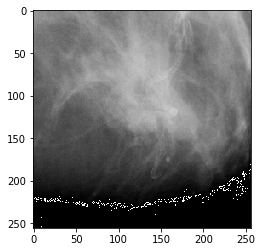

Label: [0. 0. 0. 1.]
[[[144.5546875  144.5546875  144.5546875 ]
  [146.62890625 146.62890625 146.62890625]
  [142.5        142.5        142.5       ]
  ...
  [131.29296875 131.29296875 131.29296875]
  [128.0546875  128.0546875  128.0546875 ]
  [125.1796875  125.1796875  125.1796875 ]]

 [[148.43359375 148.43359375 148.43359375]
  [147.29296875 147.29296875 147.29296875]
  [152.78515625 152.78515625 152.78515625]
  ...
  [133.0078125  133.0078125  133.0078125 ]
  [133.85546875 133.85546875 133.85546875]
  [132.734375   132.734375   132.734375  ]]

 [[148.46484375 148.46484375 148.46484375]
  [152.88671875 152.88671875 152.88671875]
  [144.6953125  144.6953125  144.6953125 ]
  ...
  [123.62890625 123.62890625 123.62890625]
  [124.83203125 124.83203125 124.83203125]
  [129.046875   129.046875   129.046875  ]]

 ...

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [  0.           0.           0.       

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [13]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [14]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [17]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [19]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 19.8129 - accuracy: 0.2837
Epoch 00001: val_loss improved from inf to 1.37285, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 32s 2s/step - loss: 18.7401 - accuracy: 0.2857 - val_loss: 1.3729 - val_accuracy: 0.2732
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.4011 - accuracy: 0.3223
Epoch 00002: val_loss did not improve from 1.37285
19/19 [==============================] - 29s 2s/step - loss: 1.4064 - accuracy: 0.3200 - val_loss: 1.3769 - val_accuracy: 0.3557
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3813 - accuracy: 0.3572
Epoch 00003: val_loss improved from 1.37285 to 1.36496, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================

Epoch 27/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2481 - accuracy: 0.4399
Epoch 00027: val_loss did not improve from 1.22393
19/19 [==============================] - 29s 2s/step - loss: 1.2461 - accuracy: 0.4384 - val_loss: 1.2371 - val_accuracy: 0.4107
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2364 - accuracy: 0.4535
Epoch 00028: val_loss improved from 1.22393 to 1.20454, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2342 - accuracy: 0.4547 - val_loss: 1.2045 - val_accuracy: 0.4570
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2124 - accuracy: 0.4567
Epoch 00029: val_loss did not improve from 1.20454
19/19 [==============================] - 29s 2s/step - loss: 1.2156 - accuracy: 0.4539 - val_loss: 1.2622 - val_accuracy: 0.4158
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2405 - accuracy: 0.4281
Epoch 00030: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.1750 - accuracy: 0.4689
Epoch 00056: val_loss did not improve from 1.17477
19/19 [==============================] - 29s 2s/step - loss: 1.1814 - accuracy: 0.4650 - val_loss: 1.2231 - val_accuracy: 0.4742
Epoch 57/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1611 - accuracy: 0.4834
Epoch 00057: val_loss did not improve from 1.17477
19/19 [==============================] - 29s 2s/step - loss: 1.1632 - accuracy: 0.4822 - val_loss: 1.2159 - val_accuracy: 0.4845
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1840 - accuracy: 0.4707
Epoch 00058: val_loss did not improve from 1.17477
19/19 [==============================] - 29s 2s/step - loss: 1.1869 - accuracy: 0.4685 - val_loss: 1.2249 - val_accuracy: 0.4416
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1851 - accuracy: 0.4657
Epoch 00059: val_loss did not improve from 1.17477
19/19 [==============================]

Epoch 86/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1522 - accuracy: 0.4935
Epoch 00086: val_loss did not improve from 1.13805
19/19 [==============================] - 29s 2s/step - loss: 1.1441 - accuracy: 0.4951 - val_loss: 1.1964 - val_accuracy: 0.4897
Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1530 - accuracy: 0.4921
Epoch 00087: val_loss did not improve from 1.13805
19/19 [==============================] - 29s 2s/step - loss: 1.1590 - accuracy: 0.4861 - val_loss: 1.1895 - val_accuracy: 0.4605
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1689 - accuracy: 0.4821
Epoch 00088: val_loss did not improve from 1.13805
19/19 [==============================] - 29s 2s/step - loss: 1.1715 - accuracy: 0.4805 - val_loss: 1.1767 - val_accuracy: 0.5017
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1447 - accuracy: 0.4984
Epoch 00089: val_loss did not improve from 1.13805
19/19 [==================

In [20]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [21]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [22]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [23]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 95
Epoch [opt]: 65
Valid accuracy [end]: 0.4656
Valid accuracy [opt]: 0.4966
Test accuracy [end]:  0.4870
Test accuracy [opt]:  0.4580
Valid loss [end]: 1.1713
Valid loss [opt]: 1.1381
Test loss [end]:  1.1437
Test loss [opt]:  1.1871


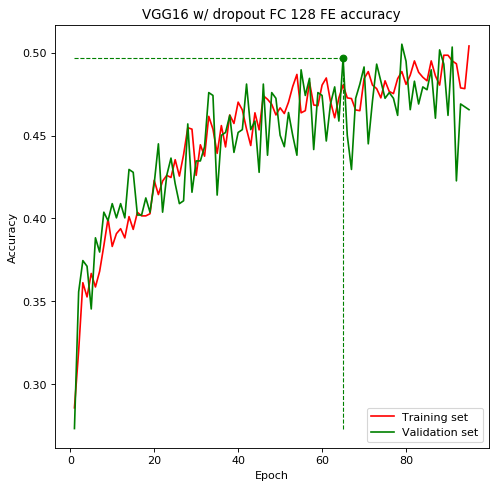

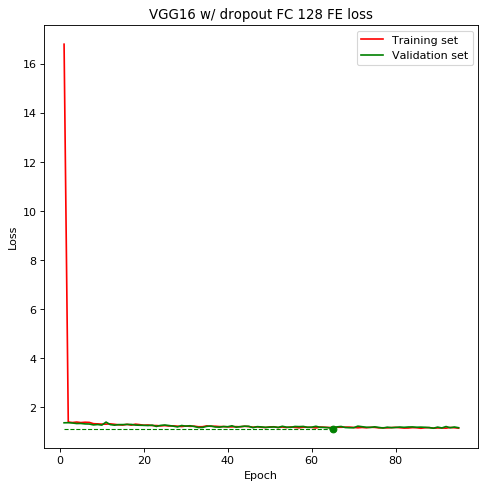

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [25]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 19.7767 - accuracy: 0.3000
Epoch 00001: val_loss improved from inf to 1.41172, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 18.8462 - accuracy: 0.3037 - val_loss: 1.4117 - val_accuracy: 0.3591
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3930 - accuracy: 0.3436
Epoch 00002: val_loss improved from 1.41172 to 1.38235, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3957 - accuracy: 0.3436 - val_loss: 1.3824 - val_accuracy: 0.3419
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3707 - accuracy: 0.3403
Epoch 00003: val_loss improved from 1.38235 to 1.34851, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1

Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2048 - accuracy: 0.4589
Epoch 00028: val_loss improved from 1.18883 to 1.18770, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2070 - accuracy: 0.4569 - val_loss: 1.1877 - val_accuracy: 0.4759
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2088 - accuracy: 0.4644
Epoch 00029: val_loss did not improve from 1.18770
19/19 [==============================] - 29s 2s/step - loss: 1.2064 - accuracy: 0.4659 - val_loss: 1.2050 - val_accuracy: 0.4759
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2002 - accuracy: 0.4721
Epoch 00030: val_loss did not improve from 1.18770
19/19 [==============================] - 29s 2s/step - loss: 1.2010 - accuracy: 0.4706 - val_loss: 1.2277 - val_accuracy: 0.4244
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2000 - accuracy: 0.4698
Epoch 00031: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.1482 - accuracy: 0.5079
Epoch 00057: val_loss did not improve from 1.16072
19/19 [==============================] - 29s 2s/step - loss: 1.1488 - accuracy: 0.5075 - val_loss: 1.2016 - val_accuracy: 0.4863
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1596 - accuracy: 0.4839
Epoch 00058: val_loss did not improve from 1.16072
19/19 [==============================] - 29s 2s/step - loss: 1.1598 - accuracy: 0.4865 - val_loss: 1.2817 - val_accuracy: 0.4708
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1703 - accuracy: 0.4843
Epoch 00059: val_loss did not improve from 1.16072
19/19 [==============================] - 29s 2s/step - loss: 1.1671 - accuracy: 0.4895 - val_loss: 1.2072 - val_accuracy: 0.4674
Epoch 60/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1664 - accuracy: 0.4948
Epoch 00060: val_loss did not improve from 1.16072
19/19 [==============================]

Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1356 - accuracy: 0.5102
Epoch 00087: val_loss did not improve from 1.15642
19/19 [==============================] - 29s 2s/step - loss: 1.1328 - accuracy: 0.5127 - val_loss: 1.1607 - val_accuracy: 0.5103
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1356 - accuracy: 0.5034
Epoch 00088: val_loss did not improve from 1.15642
19/19 [==============================] - 29s 2s/step - loss: 1.1381 - accuracy: 0.5028 - val_loss: 1.2040 - val_accuracy: 0.4639
Epoch 89/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1302 - accuracy: 0.5061
Epoch 00089: val_loss did not improve from 1.15642
19/19 [==============================] - 29s 2s/step - loss: 1.1253 - accuracy: 0.5105 - val_loss: 1.1748 - val_accuracy: 0.5034
Epoch 90/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1348 - accuracy: 0.5129
Epoch 00090: val_loss did not improve from 1.15642
19/19 [==================

In [27]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 94
Epoch [opt]: 64
Valid accuracy [end]: 0.4656
Valid accuracy [opt]: 0.4759
Test accuracy [end]:  0.4550
Test accuracy [opt]:  0.4748
Valid loss [end]: 1.1931
Valid loss [opt]: 1.1564
Test loss [end]:  1.2128
Test loss [opt]:  1.1828


In [29]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)      

In [31]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [32]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1755 - accuracy: 0.4812
Epoch 00001: val_loss improved from inf to 1.21311, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1710 - accuracy: 0.4801 - val_loss: 1.2131 - val_accuracy: 0.4536
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1191 - accuracy: 0.5089
Epoch 00002: val_loss improved from 1.21311 to 1.16955, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1225 - accuracy: 0.5058 - val_loss: 1.1696 - val_accuracy: 0.4880
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1183 - accuracy: 0.5261
Epoch 00003: val_loss improved from 1.16955 to 1.12113, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1232 - 

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9920 - accuracy: 0.5751
Epoch 00029: val_loss did not improve from 1.04609
19/19 [==============================] - 29s 2s/step - loss: 0.9896 - accuracy: 0.5787 - val_loss: 1.1371 - val_accuracy: 0.5223
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9860 - accuracy: 0.5774
Epoch 00030: val_loss did not improve from 1.04609
19/19 [==============================] - 29s 2s/step - loss: 0.9823 - accuracy: 0.5787 - val_loss: 1.0796 - val_accuracy: 0.5498
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9859 - accuracy: 0.5842
Epoch 00031: val_loss did not improve from 1.04609
19/19 [==============================] - 29s 2s/step - loss: 0.9873 - accuracy: 0.5839 - val_loss: 1.0766 - val_accuracy: 0.5430
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9751 - accuracy: 0.5806
Epoch 00032: val_loss did not improve from 1.04609
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 0.9429 - accuracy: 0.6001
Epoch 00058: val_loss did not improve from 1.01167
19/19 [==============================] - 29s 2s/step - loss: 0.9459 - accuracy: 0.5993 - val_loss: 1.1057 - val_accuracy: 0.5430
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9262 - accuracy: 0.5992
Epoch 00059: val_loss did not improve from 1.01167
19/19 [==============================] - 29s 2s/step - loss: 0.9297 - accuracy: 0.5985 - val_loss: 1.0385 - val_accuracy: 0.5687
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9230 - accuracy: 0.5942
Epoch 00060: val_loss did not improve from 1.01167
19/19 [==============================] - 29s 2s/step - loss: 0.9277 - accuracy: 0.5933 - val_loss: 1.0145 - val_accuracy: 0.5756
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9147 - accuracy: 0.6055
Epoch 00061: val_loss did not improve from 1.01167
19/19 [==============================]

Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8675 - accuracy: 0.6405
Epoch 00088: val_loss did not improve from 0.99812
19/19 [==============================] - 29s 2s/step - loss: 0.8657 - accuracy: 0.6401 - val_loss: 1.0667 - val_accuracy: 0.5430
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8651 - accuracy: 0.6387
Epoch 00089: val_loss did not improve from 0.99812
19/19 [==============================] - 29s 2s/step - loss: 0.8662 - accuracy: 0.6388 - val_loss: 1.0487 - val_accuracy: 0.5584
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8598 - accuracy: 0.6332
Epoch 00090: val_loss did not improve from 0.99812
19/19 [==============================] - 29s 2s/step - loss: 0.8639 - accuracy: 0.6328 - val_loss: 1.0564 - val_accuracy: 0.5326
Epoch 91/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8395 - accuracy: 0.6450
Epoch 00091: val_loss did not improve from 0.99812
19/19 [==================

In [33]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [34]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 94
Epoch [opt]: 64
Valid accuracy [end]: 0.5722
Valid accuracy [opt]: 0.5859
Test accuracy [end]:  0.5496
Test accuracy [opt]:  0.5389
Valid loss [end]: 1.0735
Valid loss [opt]: 0.9981
Test loss [end]:  1.0983
Test loss [opt]:  1.0939


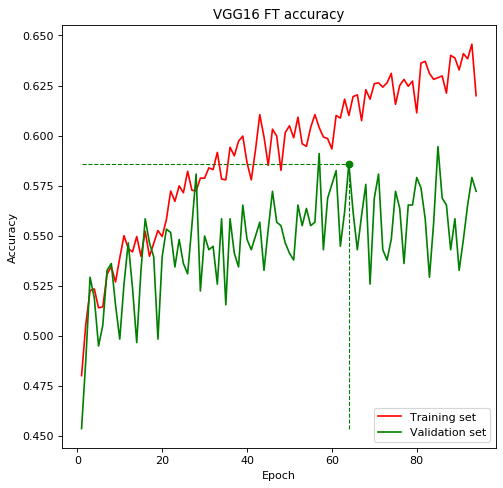

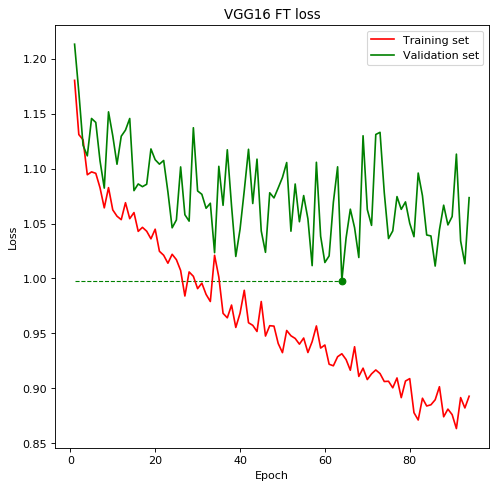

In [35]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [36]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [37]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [38]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2761 - accuracy: 0.5039
Epoch 00001: val_loss improved from inf to 1.04643, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2643 - accuracy: 0.5071 - val_loss: 1.0464 - val_accuracy: 0.5361
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0176 - accuracy: 0.5706
Epoch 00002: val_loss did not improve from 1.04643
19/19 [==============================] - 29s 2s/step - loss: 1.0194 - accuracy: 0.5727 - val_loss: 1.0530 - val_accuracy: 0.5687
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9814 - accuracy: 0.5842
Epoch 00003: val_loss did not improve from 1.04643
19/19 [==============================] - 29s 2s/step - loss: 0.9845 - accuracy: 0.5852 - val_loss: 1.0915 - val_accuracy: 0.5120
Epoch 4/200
18/19 [====================

18/19 [===========================>..] - ETA: 1s - loss: 0.8473 - accuracy: 0.6428
Epoch 00029: val_loss did not improve from 0.97662
19/19 [==============================] - 29s 2s/step - loss: 0.8520 - accuracy: 0.6414 - val_loss: 1.1077 - val_accuracy: 0.5344
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8601 - accuracy: 0.6464
Epoch 00030: val_loss did not improve from 0.97662
19/19 [==============================] - 29s 2s/step - loss: 0.8645 - accuracy: 0.6439 - val_loss: 1.0720 - val_accuracy: 0.5842
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8645 - accuracy: 0.6396
Epoch 00031: val_loss did not improve from 0.97662
19/19 [==============================] - 29s 2s/step - loss: 0.8645 - accuracy: 0.6384 - val_loss: 1.0892 - val_accuracy: 0.5962
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8626 - accuracy: 0.6350
Epoch 00032: val_loss did not improve from 0.97662
19/19 [==============================]

Epoch 00058: early stopping


In [39]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [40]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 58
Epoch [opt]: 28
Valid accuracy [end]: 0.5498
Valid accuracy [opt]: 0.5928
Test accuracy [end]:  0.5969
Test accuracy [opt]:  0.5344
Valid loss [end]: 1.1547
Valid loss [opt]: 0.9766
Test loss [end]:  0.9954
Test loss [opt]:  1.1099


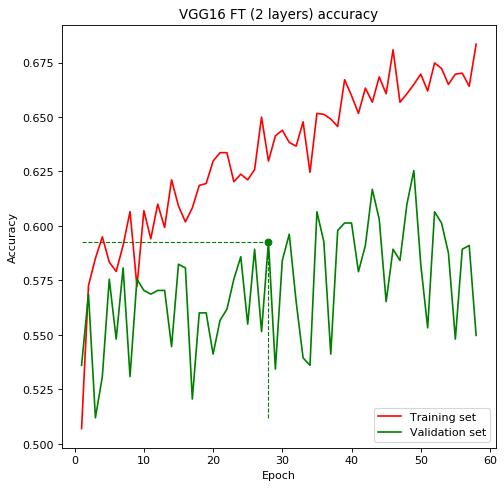

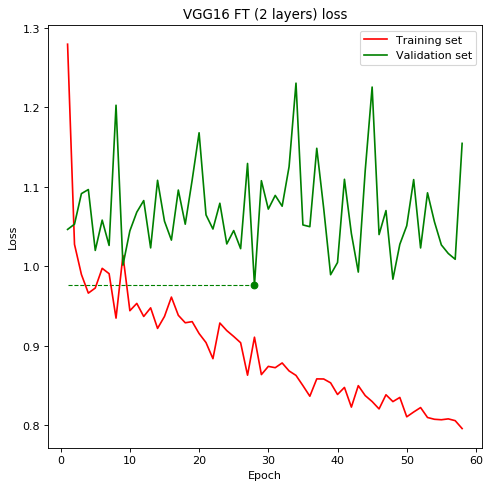

In [41]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [42]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 15,469,316
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [43]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [44]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8160 - accuracy: 0.6718
Epoch 00001: val_loss improved from inf to 0.97851, saving model to vgg16_ft_3layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.8228 - accuracy: 0.6701 - val_loss: 0.9785 - val_accuracy: 0.6151
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8124 - accuracy: 0.6741
Epoch 00002: val_loss did not improve from 0.97851
19/19 [==============================] - 29s 2s/step - loss: 0.8092 - accuracy: 0.6735 - val_loss: 1.0150 - val_accuracy: 0.5945
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7945 - accuracy: 0.6859
Epoch 00003: val_loss did not improve from 0.97851
19/19 [==============================] - 29s 2s/step - loss: 0.7945 - accuracy: 0.6873 - val_loss: 1.0518 - val_accuracy: 0.5790
Epoch 4/200
18/19 [====================

Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7172 - accuracy: 0.7122
Epoch 00030: val_loss did not improve from 0.97397
19/19 [==============================] - 29s 2s/step - loss: 0.7202 - accuracy: 0.7100 - val_loss: 1.0099 - val_accuracy: 0.5979
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7303 - accuracy: 0.7036
Epoch 00031: val_loss did not improve from 0.97397
19/19 [==============================] - 29s 2s/step - loss: 0.7289 - accuracy: 0.7036 - val_loss: 1.0171 - val_accuracy: 0.5997
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7342 - accuracy: 0.6977
Epoch 00032: val_loss did not improve from 0.97397
19/19 [==============================] - 29s 2s/step - loss: 0.7276 - accuracy: 0.7010 - val_loss: 0.9932 - val_accuracy: 0.6186
Epoch 33/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7244 - accuracy: 0.6950
Epoch 00033: val_loss did not improve from 0.97397
19/19 [==================

Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.7149
Epoch 00060: val_loss did not improve from 0.91616
19/19 [==============================] - 29s 2s/step - loss: 0.6864 - accuracy: 0.7164 - val_loss: 1.0061 - val_accuracy: 0.6065
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6979 - accuracy: 0.7263
Epoch 00061: val_loss did not improve from 0.91616
19/19 [==============================] - 29s 2s/step - loss: 0.6890 - accuracy: 0.7314 - val_loss: 1.0056 - val_accuracy: 0.6048
Epoch 62/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7140 - accuracy: 0.7248
Epoch 00062: val_loss did not improve from 0.91616
19/19 [==============================] - 29s 2s/step - loss: 0.6954 - accuracy: 0.7272 - val_loss: 1.0243 - val_accuracy: 0.6065
Epoch 63/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6911 - accuracy: 0.7108
Epoch 00063: val_loss did not improve from 0.91616
19/19 [==================

In [45]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [46]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 70
Epoch [opt]: 40
Valid accuracy [end]: 0.6082
Valid accuracy [opt]: 0.6375
Test accuracy [end]:  0.5756
Test accuracy [opt]:  0.5725
Valid loss [end]: 0.9956
Valid loss [opt]: 0.9162
Test loss [end]:  1.1887
Test loss [opt]:  1.1797


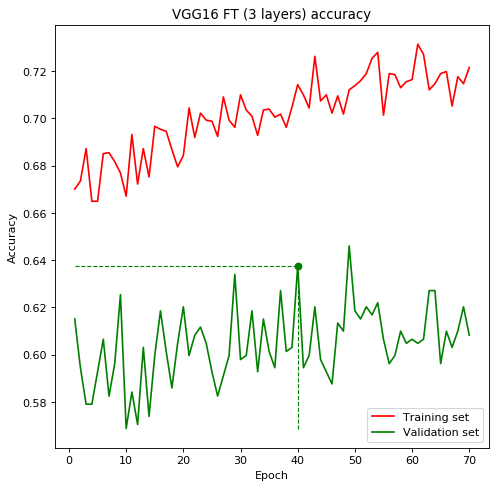

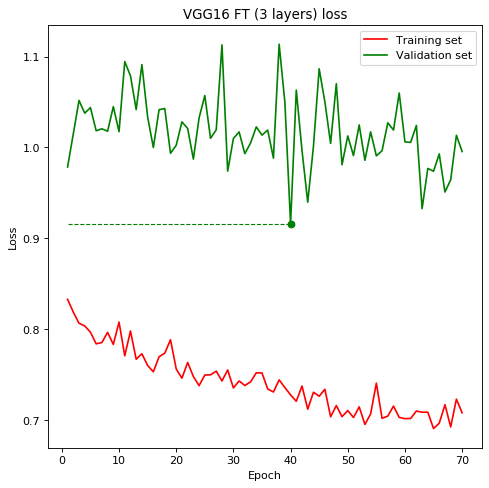

In [47]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();